In [13]:
#+.+
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models,datasets,transforms
from PIL import Image 
from PIL import UnidentifiedImageError
import os
import shutil
from safe_dataset import SafeImageFolder
from sklearn.metrics import confusion_matrix, classification_report
import random

**PRE-PROCESSING**

After a (very) long process of looping over all 48,000 training images one by one (which we omit here for sanity purposes) to get the average pixel values per channel (R,G,B) across all pixels in all images in our dataset and their associated standard deviation, we obtained the following: 

mean: [0.4506, 0.4247, 0.3930]

std: [0.2247, 0.2102, 0.2054]

This was done to prepare the images for our CNN in order to normalize pixel values to have a mean of ~0 and variance ~1 per channel, and now all channels are on a similar scale. 

In [2]:
train_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.3), #subtle random flip for generalization
    transforms.RandomRotation(5), #subtle random rotation for generalization
    transforms.ColorJitter(brightness=0.05,contrast=0.05,saturation=0.05), #subtle random light/color variation for generalization
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4506,0.4247,0.3930],
                         std=[0.2247,0.2102,0.2054])
])

test_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4506,0.4247,0.3930],
                         std=[0.2247,0.2102,0.2054])
])

#train_dataset=datasets.ImageFolder('data/train',transform=train_transforms)
#test_dataset=datasets.ImageFolder('data/test',transform=test_transforms)
train_dataset = SafeImageFolder('data/train', transform=train_transforms)
test_dataset = SafeImageFolder('data/test', transform=test_transforms)
train_loader=DataLoader(train_dataset,batch_size=64,shuffle=True,num_workers=4,pin_memory=True) #shuffle=True to randomize order each epoch for training
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False,num_workers=4,pin_memory=True)

#checks: 
print("Training samples: ",len(train_dataset))
print("Test samples: ",len(test_dataset))
images,labels=next(iter(train_loader))
print(train_dataset.class_to_idx)
print("Labels in batch: ",labels)
print("Batch shape: ",images.shape)

Training samples:  48000
Test samples:  12000
{'fake': 0, 'real': 1}
Labels in batch:  tensor([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1])
Batch shape:  torch.Size([64, 3, 224, 224])


We also prepare to transform the data in this step. For both test and train sets we resized the images to 224x224 pixels, and normalized the pixel colors to the overall (training) data RGB means. For the training data we added some additional (subtle) transformations to better generalize to unseen data, these include: horizontal flip, rotation, color variations. 

**MODELING**

Our modeling consists of several key steps: 

1. We choose to run the model on the Apple GPU (Metal Performance Shaders "mps")
2. Load a pretrained ResNet-18 model (trained on ImageNet)
    - Replace the final layer ("model.fc", which predicts 1000 classes) with a linear layer that predicts 2 classes (fake vs. real)
    - Send the model to the GPU 
3. Define the loss function and optimizer 
    - CrossEntropyLoss used for loss (standard for classification)
    - Adam used for optimizer (updates model weights using gradients)
4. Training loop
    - Train 5 times (epochs)
    - Load batches -> move them to GPU -> forward pass -> loss step (measures prediction error) -> backward pass (computes gradients) -> optimizer step (updates model parameters) -> track loss across all batches to show epoch progress
5. Evaluation/Testing
    - Disable training behaviors
    - Turn off gradient tracking to save memory and speed up inference
    - Loop through test images, get predictions, count how many match true labels and print acccuracy

In [3]:
device=torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:",device)
model=models.resnet18(pretrained=True)
num_ftrs=model.fc.in_features
model.fc=nn.Linear(num_ftrs,2)
model=model.to(device)
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=1e-4)

num_epochs=5
for epoch in range(num_epochs): 
    model.train()
    running_loss=0.0
    for images,labels in train_loader: 
        images,labels=images.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()*images.size(0)
    epoch_loss=running_loss/len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

model.eval()
correct=0
total=0
with torch.no_grad(): 
    for images,labels in test_loader: 
        images,labels=images.to(device),labels.to(device)
        outputs=model(images)
        _,preds=torch.max(outputs,1)
        correct+=(preds==labels).sum().item()
        total+=labels.size(0)
print("Test accuracy: ",correct/total)
print(f"Total correct predictions: {correct}/{total}")

Using device: mps


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


⚠️ Skipping bad image: data/train/real/16011.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90671520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/fake/12854.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


⚠️ Skipping bad image: data/train/real/13021.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


⚠️ Skipping bad image: data/train/real/21610.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/real/20964.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/real/12094.jpg
⚠️ Skipping bad image: data/train/real/15963.jpg
⚠️ Skipping bad image: data/train/fake/8022.jpg
⚠️ Skipping bad image: data/train/real/0038.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (107184040 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (99991727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96012000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/5, Loss: 0.2526
⚠️ Skipping bad image: data/train/fake/12854.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


⚠️ Skipping bad image: data/train/real/13021.jpg
⚠️ Skipping bad image: data/train/real/21610.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


⚠️ Skipping bad image: data/train/real/0038.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (107184040 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452:

⚠️ Skipping bad image: data/train/real/12094.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/real/15963.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96012000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/real/20964.jpg
⚠️ Skipping bad image: data/train/real/16011.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (99991727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/fake/8022.jpg
Epoch 2/5, Loss: 0.1643
⚠️ Skipping bad image: data/train/real/0038.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/real/15963.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


⚠️ Skipping bad image: data/train/real/13021.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


⚠️ Skipping bad image: data/train/fake/12854.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (99991727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/real/20964.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/real/16011.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (107184040 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/real/12094.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90671520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/real/21610.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96012000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/fake/8022.jpg
Epoch 3/5, Loss: 0.1254


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


⚠️ Skipping bad image: data/train/real/13021.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


⚠️ Skipping bad image: data/train/fake/8022.jpg
⚠️ Skipping bad image: data/train/real/21610.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96012000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/fake/12854.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (107184040 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (99991727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/real/20964.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90671520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/real/15963.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/real/0038.jpg
⚠️ Skipping bad image: data/train/real/16011.jpg
⚠️ Skipping bad image: data/train/real/12094.jpg
Epoch 4/5, Loss: 0.1000


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98058240 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


⚠️ Skipping bad image: data/train/real/16011.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (99991727 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/fake/12854.jpg
⚠️ Skipping bad image: data/train/real/12094.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (98806617 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/fake/8022.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96012000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/real/13021.jpg
⚠️ Skipping bad image: data/train/real/20964.jpg
⚠️ Skipping bad image: data/train/real/0038.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (96000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (161087488 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (107184040 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


⚠️ Skipping bad image: data/train/real/21610.jpg
⚠️ Skipping bad image: data/train/real/15963.jpg


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (90671520 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5/5, Loss: 0.0840


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (143040000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (121554000 pixels) e

⚠️ Skipping bad image: data/test/real/5197.jpg
⚠️ Skipping bad image: data/test/real/5325.jpg
⚠️ Skipping bad image: data/test/real/5879.jpg
Test accuracy:  0.932
Total correct predictions: 11184/12000


In [5]:
torch.save(model.state_dict(), "my_model.pth")
print("✅ Model saved to 'my_model.pth'")

✅ Model saved to 'my_model.pth'


**Our model has pretty outstanding accuracy on the test set: ~93% !**

In [ ]:
all_preds=[]
all_labels=[]
correct=0
total=0

with torch.no_grad(): 
    for images,labels in test_loader: 
        images,labels=images.to(device),labels.to(device)
        outputs=model(images)
        _,preds=torch.max(outputs,1)
        
        correct+=(preds==labels).sum().item()
        total+=labels.size(0)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy=correct/total
print(f"Test accuracy: {accuracy:.4f}")
print(f"Total correct predictions: {correct}/{total}")

cm=confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n",cm)

report=classification_report(all_labels,all_preds,target_names=['class0','class1'])
print("Classification Report:\n",report)


/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (143040000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/enzo/opt/anaconda3/envs/torch_env/lib/python3.12/site-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (121554000 pixels) e

⚠️ Skipping bad image: data/test/real/5197.jpg
⚠️ Skipping bad image: data/test/real/5325.jpg
⚠️ Skipping bad image: data/test/real/5879.jpg
Test accuracy: 0.9320
Total correct predictions: 11184/12000
Confusion Matrix:
 [[5442  558]
 [ 258 5742]]
Classification Report:
               precision    recall  f1-score   support

      class0       0.95      0.91      0.93      6000
      class1       0.91      0.96      0.93      6000

    accuracy                           0.93     12000
   macro avg       0.93      0.93      0.93     12000
weighted avg       0.93      0.93      0.93     12000



,precision,recall,f1-score
Fake,0.955,0.907,0.930
Real,0.911,0.957,0.934


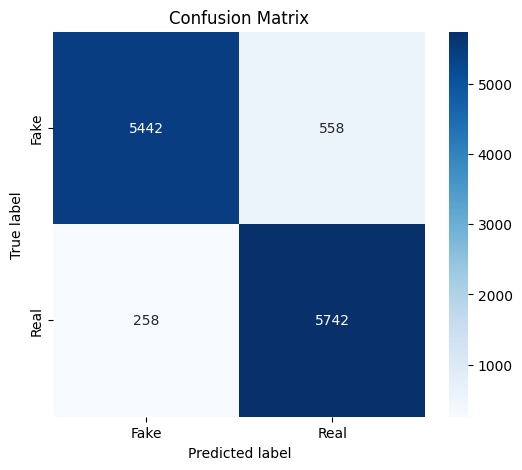

In [12]:
report_dict=classification_report(all_labels,all_preds,target_names=['Fake','Real'],output_dict=True)
report_df=pd.DataFrame(report_dict).transpose()
display(report_df.loc[['Fake','Real'],['precision','recall','f1-score']].round(3))
cm=confusion_matrix(all_labels,all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
            xticklabels=['Fake','Real'],
            yticklabels=['Fake','Real'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Awesome, looks like the model performs very well. 

Both classes show high precision, recall, and F1- scores, indicating a strong balance between correctly identifying each class and minimizing false predictions. 

From the confusion matrix, most samples are correctly classified, only a small fraction are misclassified. This suggests themodel has learned to distinguish between fake and real images reliably, with only minor overlap or ambiguity between the two categories. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0204568..2.115146].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0053403..2.611547].


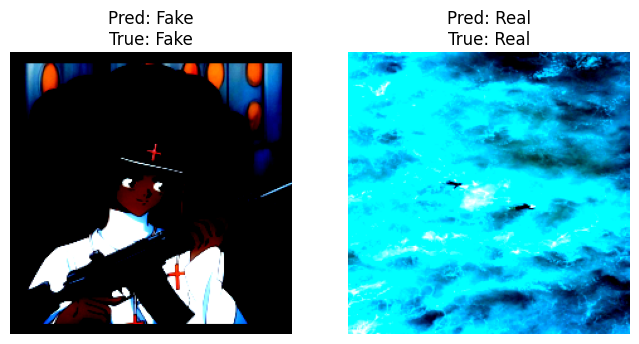

In [24]:
fake_indices=[i for i,p in enumerate(all_preds) if p==0]
real_indices = [i for i,p in enumerate(all_preds) if p==1]

if fake_indices and real_indices:
    idx_fake=random.choice(fake_indices)
    idx_real=random.choice(real_indices)
    fake_img,fake_label=test_loader.dataset[idx_fake]
    real_img,real_label=test_loader.dataset[idx_real]

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(fake_img.permute(1,2,0)) 
    plt.title(f"Pred: Fake\nTrue: {'Fake' if fake_label==0 else 'Real'}")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(real_img.permute(1,2,0))
    plt.title(f"Pred: Real\nTrue: {'Fake' if real_label==0 else 'Real'}")
    plt.axis('off')
    plt.show()